# **NLP-Based Review Classification Pipeline for Fashion Product Recommendations**

# **Data Exploration**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB
None
Recommended IND
1    15053
0     3389
Name: count, dtype: int64


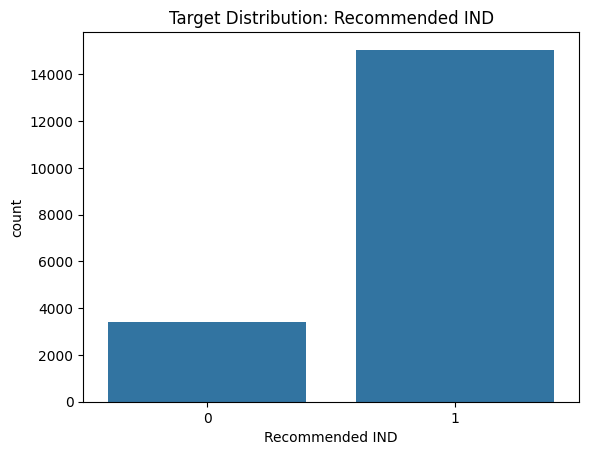

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('reviews.csv')

# Check structure
print(df.info())
print(df['Recommended IND'].value_counts())

# Visualize class distribution
sns.countplot(x='Recommended IND', data=df)
plt.title("Target Distribution: Recommended IND")
plt.show()

# Check missing values (should be none)
print(df.isnull().sum())

# Preview data
df.head()


# **Preparing Features and Target**

In [2]:
# Define features and target
X = df.drop('Recommended IND', axis=1)
y = df['Recommended IND']

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=27, shuffle=True
)


# **Building Preprocessing Pipelines**

In [3]:
import spacy
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# spaCy tokenizer
def spacy_tokenizer(text):
    doc = nlp(str(text))
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

# Feature groups
numeric_features = ['Age', 'Positive Feedback Count']
categorical_features = ['Clothing ID', 'Division Name', 'Department Name', 'Class Name']
text_features = 'Review Text'

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer, max_features=500))
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
    ('txt', text_pipeline, text_features)
])


# **Creating model pipeline**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Train
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Positive Feedback Count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Clothing ID',
                                                   'Division Name',
                                                   'Department Name',
                                                   'Class Name']),
                                                 ('txt',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   tokenizer=<function spacy_tokenizer at 0x7b2d4b3c28e0>))]),
                                                  'Review Text')])),
                ('classifier', LogisticRegression(max_iter=500))])

# **Evaluating the model**

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


[[ 152  175]
 [  62 1456]]
              precision    recall  f1-score   support

           0       0.71      0.46      0.56       327
           1       0.89      0.96      0.92      1518

    accuracy                           0.87      1845
   macro avg       0.80      0.71      0.74      1845
weighted avg       0.86      0.87      0.86      1845

Accuracy: 0.8715447154471545


# **Fine-tuning with GridSearch**

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)io

print("Best params:", grid_search.best_params_)

# Evaluate best model
y_pred_best = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_best))


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extr

Best params: {'classifier__C': 1}
              precision    recall  f1-score   support

           0       0.71      0.46      0.56       327
           1       0.89      0.96      0.92      1518

    accuracy                           0.87      1845
   macro avg       0.80      0.71      0.74      1845
weighted avg       0.86      0.87      0.86      1845



# **Confusion Matrix Visualization**

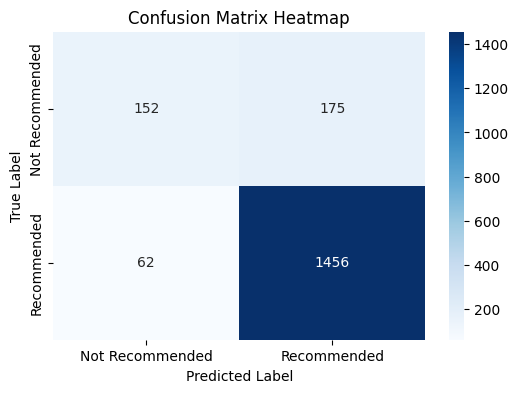

In [7]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Recommended', 'Recommended'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


# **Influential TF-IDF Terms**

/tmp/ipython-input-9-2899339923.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=terms, palette="crest")


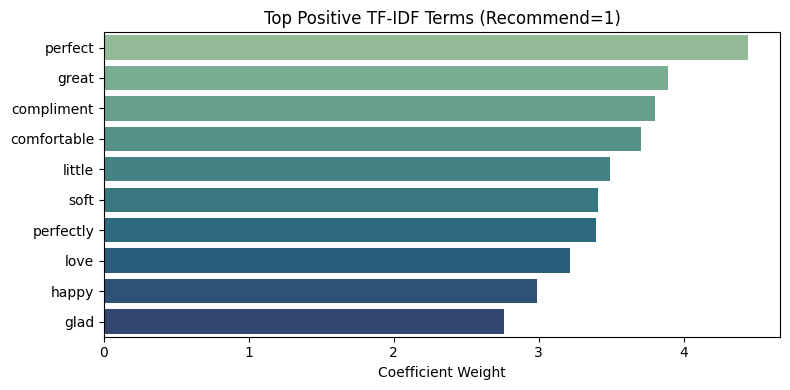

/tmp/ipython-input-9-2899339923.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=terms, palette="crest")


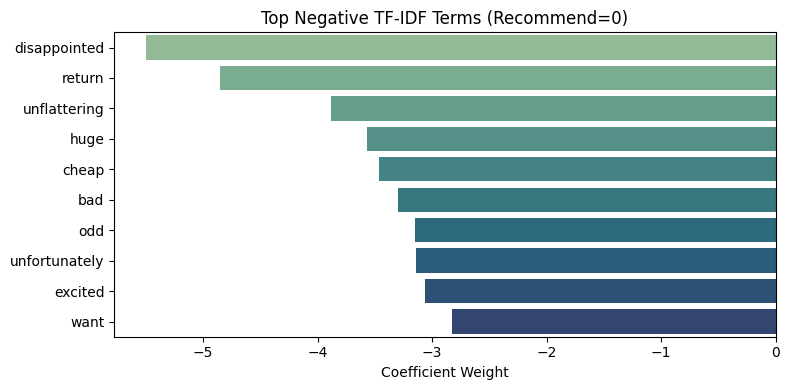

In [9]:
# Access components
preprocessor = grid_search.best_estimator_.named_steps['preprocessing']
tfidf_vectorizer = preprocessor.named_transformers_['txt'].named_steps['tfidf']
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Total number of features in numeric + categorical parts
num_num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].n_features_in_
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
num_cat_features = len(cat_feature_names)

# Where TF-IDF features start in coef_ vector
tfidf_start_index = num_num_features + num_cat_features

# Get only the TF-IDF-related coefficients
coef_all = grid_search.best_estimator_.named_steps['classifier'].coef_[0]
tfidf_coefs = coef_all[tfidf_start_index: tfidf_start_index + len(feature_names_tfidf)]

# Top positive and negative TF-IDF features
top_n = 10
top_pos_idx = np.argsort(tfidf_coefs)[-top_n:][::-1]
top_neg_idx = np.argsort(tfidf_coefs)[:top_n]

top_pos_terms = [(feature_names_tfidf[i], tfidf_coefs[i]) for i in top_pos_idx]
top_neg_terms = [(feature_names_tfidf[i], tfidf_coefs[i]) for i in top_neg_idx]

# Plotting function
def plot_top_terms(term_weights, title):
    terms, weights = zip(*term_weights)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=weights, y=terms, palette="crest")
    plt.title(title)
    plt.xlabel("Coefficient Weight")
    plt.tight_layout()
    plt.show()

plot_top_terms(top_pos_terms, "Top Positive TF-IDF Terms (Recommend=1)")
plot_top_terms(top_neg_terms, "Top Negative TF-IDF Terms (Recommend=0)")



# **Saving the model**

In [10]:
import joblib
joblib.dump(grid_search.best_estimator_, 'fashion_recommendation_pipeline.pkl')


['fashion_recommendation_pipeline.pkl']

In [11]:
import os
os.getcwd()


'/content'

In [12]:
from google.colab import files
files.download('fashion_recommendation_pipeline.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>